# Homework 5

## The Heat Equation

### This is the solution of:
* Klas Henriksson klhe0017@student.umu.se
* Joel Nilsson joni0295@student.umu.se
* Daniel Dahlgren Lindström dali0125@student.umu.se



The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$

In [3]:
### Make plotted figures interactive
#%matplotlib notebook

# Download the updated plottools.py file from lab_05 and import it!
import plottools as pt
from scipy.sparse.linalg.dsolve import spsolve
import scipy.sparse as sp

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.style.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style. 
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: './custom.style.css'

In this problem set you are asked to implement the $\theta$ scheme 
combined with the either the finite difference method or the finite element method
as space discretization to solve the heat equation

\begin{alignat*}{3}
\partial_t u  - \Delta u  &= f  \quad && \text{in } \Omega \times (0,T]
\\
u &= g_D \quad && \text{on } \partial \Omega \times (0, T]
\\
u(x,0) &=  u_0(x) \quad && \text{in } \Omega
\end{alignat*}

with initial value $u_0$ and bounday value $g_D$.

Given a start time $t_0$, end time $T$, number of time steps $M$ and a time step size $\tau = (T-t_0)/M$, recall that the $\theta$-scheme resulted in a full discretization of the heat equation of the general form
\begin{align*}
(B_h + \theta \tau A_h) U^k = (B_h - \overline{\theta} \tau A_h) U^{k-1}
+ \widetilde{F}^k \quad k = 1,\ldots, M
\end{align*}
plus boundary conditions. As before, we define $\overline{\theta} = 1 - \theta$.

## Problem 1 (Finite Difference Methods)

**a**) Implement a full discretization for the 2d heat equation with 
* $\Omega = (0, 2\pi)^2$
* $f = 0$
* $g_D = 0$
* $u(x,y,0) = \sin(x)\sin(y)$

by combining the $\theta$ scheme with a finite difference scheme in space. Take the following code outline as starting point. 

First, implement a function which computes the finite difference matrix generating by the 5 point stencil. Steal as much code as possible from the 2d finite difference scheme for the Poisson problem you implemented in Lab 02.

In [4]:
def fdm_poisson2d_matrix(h, N, gm):
    """Computes sparse matrix representation for a simple finite difference scheme in space.
      
    Parameters:
    ----------
    h: float
       spatial mesh size
       here choosen the same in each spatial direction
    N: integer
       number of space subdivision in each spatial direction.
    gm: function
       grid mapping which translates double grid indices (i, j) to index of the unknown
       
    Returns:
    -------
    A: 2D sparse matrix of type dok_matrix
        Matrix for diffusion equation
    """
    # Allocate a (sparse)
    N_unk = (N+1)**2
    A = sp.dok_matrix((N_unk, N_unk))

    hh = h*h

    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = gm(i,j)       
            A[ri,gm(i,j)] = 4/hh # U_ij
            A[ri,gm(i-1,j)] = -1/hh   # U_{i-1,j}
            A[ri,gm(i+1, j)] = -1/hh    # U_{i+1,j}
            A[ri,gm(i,j-1)] = -1/hh    # U_{i,j-1}
            A[ri,gm(i,j+1)] = -1/hh    # U_{i,j+1}

    return A

You will also need a tiny function which applies the boundary conditions at time $t^k$
to a given right-hand side. Make sure that you understand the following code. Note that $F$ is the right-hand side of the $\theta$ scheme, not only the forcing function.

In [5]:
def apply_bcs(F, g_D, N, gm):
    """Apply boundary conditions defined by g_D to F. 

    Parameters:
    ----------
    F: array of float
        Given Right-hand side
    g_D: array  of float  
        Contains the values of g_D(x,y,t^k) at *all* grid points (flattened out)

    N: integer
        number of space subdivision in each spatial direction.

    gm: function
        grid mapping which translates double grid indices (i, j) to index of the unknown

    Returns: nothing
    -------
    """
    # Add boundary values related to unknowns from the first and last grid ROW
    bc_indices = [ gm(i, j)  for i in [0, N] for j in range(0, N+1) ]
    F[bc_indices] = g_D[bc_indices] 

    # Add boundary values related to unknowns from the first and last grid COLUMN
    bc_indices = [ gm(i, j) for j in [0, N] for i in range(0, N+1) ]
    F[bc_indices] = g_D[bc_indices]

Now you are ready to implement the solution overall scheme. Start by defining functions representing the data of the problem.

In [23]:
# Right hand side
def f(x, y, t):
    # Since we will use a sparse grid representation for x and y
    # this code returns the proper array representing 0 on the grid:)
    return 0*np.ones_like(x)*np.ones_like(y)

# Initial condition
def u_0(x, y):
    return np.sin(x)*np.sin(y)
    
# Boundary condition
def g_D(x, y, t):
    return 0*np.ones_like(x)*np.ones_like(y)

# Start/end time
t0, T = 0, 1

Now define your grids in space and time stepping related variable.

Size of time step tau = 1.449275e-02
Number of time step M = 69


/Users/joelnilsson/Documents/Dokument_Joels_MacPro/Universitet/numPDE/lab4/numpde-main-2/lab5/plottools.py:65: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


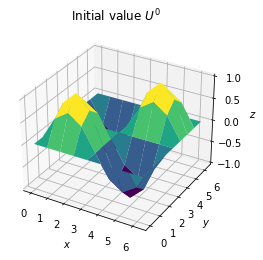

In [7]:
import numpy as np
# Define number of subdivision in each spatial direction
N = 8

# Step size
h = (2*np.pi)/N

# Define gridmap assuming a row-wise numbering (Steal it from Lab 02) 
def gm(i,j):
    return i + j * (N+1)

#  Define (sparse) grid representation for evaluation of F
#  and plotting
L = 2*np.pi
X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]

# Choose first tau and then number of step size accordingly (or the other way around). 
M = 69
tau = (T-t0)/M

# This would be a safe choice of tau satisfying the CFL condition
# alpha = 0.1
#tau = alpha*h*h/4

print("Size of time step tau = %e" % tau)
print("Number of time step M = %d" %M)

# Define your theta 
theta = 0.5
bartheta = 1 - theta

# Total number of unknowns is N_unk = (N+1)*(N+1)
N_unk = (N+1)**2

# Sparse identity matrix ajnd convert it immediately to csc format (not csr this time!)
Id = sp.identity(N_unk).tocsc()

# Compute A_h (only needed once!)
# and convert it immediately to csc format for fast matrix*vector multiplication 
# and fast matrix addition
A_h = fdm_poisson2d_matrix(h, N, gm)

# Compute total matrix B_h + tau*theta A_h
A_tot = Id + tau*theta*A_h

A_tot_LU = sp.linalg.factorized(A_tot)

# Compute total matrix B_h - tau*bartheta A_h
B_tot = Id - tau*bartheta*A_h

# Current time and time step
t, k = t0, 0

# Initial condition 
# Compute and plot it first
U_grid = u_0(X, Y)
pt.plot2D(X, Y, U_grid, title="Initial value $U^0$")

# We have to flatten out the resulting (N+1)*(N+1) array using ravel()
U = U_grid.ravel()
U_list = [ U_grid ]

Now everything is in place to start the time loop.
Mkae sure that in the last line being printed, it says t=1! 

In [7]:
# Start time stepping 
while t < T:
    # New time and time step
    t += tau
    k += 1
    print("Solving for time step k=%d and time t=%e" %(k,t))

    # Compute right hand side by
    # 1) Apply matrix Id -  bartheta \tau A_h to U^{k-1} 
    rhs = B_tot@U # Matrix-vector multiplication
    
    # 2) Compute contributions from f at t^{k-1} and t^k
    rhs += tau*bartheta*f(X, Y, t-tau).ravel()
    rhs += tau*bartheta*f(X,Y,t).ravel()

    # Compute and apply bcs to rhs
    G_D = g_D(X, Y, t).ravel()
    apply_bcs(rhs, G_D, N, gm)

    #Solve system (only necessary for theta > 0)
    if theta != 0:
        U = A_tot_LU(rhs)
    else:
        U = rhs

    U_list.append(U.copy().reshape((N+1, N+1)))

Solving for time step k=1 and time t=1.449275e-02
Solving for time step k=2 and time t=2.898551e-02
Solving for time step k=3 and time t=4.347826e-02
Solving for time step k=4 and time t=5.797101e-02
Solving for time step k=5 and time t=7.246377e-02
Solving for time step k=6 and time t=8.695652e-02
Solving for time step k=7 and time t=1.014493e-01
Solving for time step k=8 and time t=1.159420e-01
Solving for time step k=9 and time t=1.304348e-01
Solving for time step k=10 and time t=1.449275e-01
Solving for time step k=11 and time t=1.594203e-01
Solving for time step k=12 and time t=1.739130e-01
Solving for time step k=13 and time t=1.884058e-01
Solving for time step k=14 and time t=2.028986e-01
Solving for time step k=15 and time t=2.173913e-01
Solving for time step k=16 and time t=2.318841e-01
Solving for time step k=17 and time t=2.463768e-01
Solving for time step k=18 and time t=2.608696e-01
Solving for time step k=19 and time t=2.753623e-01
Solving for time step k=20 and time t=2.

Plot the solution at the final time.

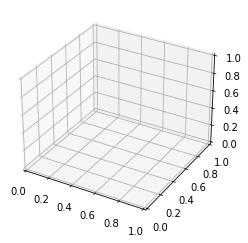

In [8]:
U_grid = U.reshape((N+1,N+1))
pt.plot_2D_animation(X,Y,U_list,zlim=(-1,1))

Finally, since static plots are boring when you simulate time-dependent
problems, we generate some animated plots. To do so, make sure that 
you have downloaded the updated ```plottools.py```. Next, adapt you code as follows

1) Store your solutions into a list as follows. Start by storing the initial
value by setting

    U_list = [ U_grid ]

before you start the time loop.

2) Add the code line

```Python
    U_list.append(U.copy().reshape((N+1,N+1)))
```
right after to solved for the new U in your current time step.

3) Add the line 

    pt.plot_2D_animation(X, Y, U_list)

after the time loop.
    
In the ```plot_2D_animation``` you can even set an animation
```duration```, a ```title``` and the limits of the $z$-axis,
e.g. ```zlim = (-1,1)```.

**Remark:** If you ever want to plot two animated plots from within a single jupyter notebook cell, you have to store
the animation object returns from  ```plot_2D_animation```, e.g.
```Python

ani_1 = pt.plot_2D_animation(X, Y, U_1_list)
ani_2 = pt.plot_2D_animation(X, Y, U_2_list)



```


**b**) Observe that at each time step $t^k$, we solve a discrete system 
$(B_h + \theta \tau A_h) U^k = F^k$ where only the right-hand side changes with each time step.
Thus, to speed up the simulation,  we can precompute a $LU$ decomposition of the matrix
$(B_h + \theta \tau A_h)$ before the time-stepping starts and then simply apply
a forward and backward substitution to compute the new $U^k$. To this end, you only need to
integrate the following code snippets in the appropriate places:

### Code snippets

In [9]:
# To precompute LU factorization (BTW: this requries the csc format to be an efficient operation)
solve = factorized(A_tot)

NameError: name 'factorized' is not defined

and

In [ ]:
# Solve using a backward/forward substitution
U = solve( rhs )

**c**)Next, we compare our computed solution with an exact one. First, take the ansatz $u_{ex}(x,y,t) = e^{\lambda t} u_0(x,y)$, plug in into your heat equation and determine the lambda in order to obtain an exact analytical solution to heat equation problem
with $f = 0$.

$$\frac{\partial u_{ex}}{\partial t} = \lambda u_{ex} $$
$$ \nabla u_0 = \left(cos(x)sin(y), cos(y)sin(x)\right) $$
$$ \Delta u_0 = -sin(x)sin(y) - sin(x)sin(y) = -2u_0 $$
$$ \Delta u_{ex} = e^{\lambda t}\Delta u_0 = -2e^{\lambda t}u_0 = -2 u_{ex} $$
$$ \lambda u_{ex} = -2 u_{ex} \Rightarrow \lambda = -2 $$

Now plot the exact solution $u$, the computed solution $U$ and their difference
at the final time for spatial mesh sizes $h = 2\pi/N$, $N=10, 20, 40$ and for $\theta \in \{ 0, 1, 0.5\}$ 

Do you see a seond order convergence in maximum norm?

In [9]:
def fdm_solve(t0, t1, M, X, Y, theta, u0, gD, f,tau):
    # Step size
    L = X[len(X)-1]-X[0]
    h = X[1]-X[0]
    N = int(L/h)

    # Define gridmap assuming a row-wise numbering (Steal it from Lab 02) 
    def gm(i,j):
        return i + j * (N+1)

    #  Define (sparse) grid representation for evaluation of F
    #  and plotting

    # Choose first tau and then number of step size accordingly (or the other way around). 
    

    # This would be a safe choice of tau satisfying the CFL condition
    # alpha = 0.1
    #tau = alpha*h*h/4

    print("Size of time step tau = %e" % tau)
    print("Number of time step M = %d" %M)

    # Define your theta 
    bartheta = 1 - theta

    # Total number of unknowns is N_unk = (N+1)*(N+1)
    N_unk = (N+1)**2

    # Sparse identity matrix ajnd convert it immediately to csc format (not csr this time!)
    Id = sp.identity(N_unk).tocsc()

    # Compute A_h (only needed once!)
    # and convert it immediately to csc format for fast matrix*vector multiplication 
    # and fast matrix addition
    A_h = fdm_poisson2d_matrix(h, N, gm)

    # Compute total matrix B_h + tau*theta A_h
    A_tot = Id + tau*theta*A_h

    A_tot_LU = sp.linalg.factorized(A_tot)

    # Compute total matrix B_h - tau*bartheta A_h
    B_tot = Id - tau*bartheta*A_h

    # Current time and time step
    t, k = t0, 0

    # Initial condition 
    # Compute and plot it first
    U_grid = u0(X, Y)
    #pt.plot2D(X, Y, U_grid, title="Initial value $U^0$")

    # We have to flatten out the resulting (N+1)*(N+1) array using ravel()
    U = U_grid.ravel()
    U_list = [ U_grid ]
    
    # Start time stepping 
    while t < t1:
        # New time and time step
        t += tau
        k += 1
        #print("Solving for time step k=%d and time t=%e" %(k,t))

        # Compute right hand side by
        # 1) Apply matrix Id -  bartheta \tau A_h to U^{k-1} 
        rhs = B_tot@U # Matrix-vector multiplication

        # 2) Compute contributions from f at t^{k-1} and t^k
        rhs += tau*bartheta*f(X, Y, t-tau).ravel()
        rhs += tau*bartheta*f(X,Y,t).ravel()

        # Compute and apply bcs to rhs
        G_D = gD(X, Y, t).ravel()
        apply_bcs(rhs, G_D, N, gm)

        #Solve system (only necessary for theta > 0)
        if theta != 0:
            U = A_tot_LU(rhs)
        else:
            U = rhs

        U_list.append(U.copy().reshape((N+1, N+1)))
    return U_list

<class 'float'>
THETA = 0
N = 10
Size of time step tau = 1.449275e-02
Number of time step M = 69


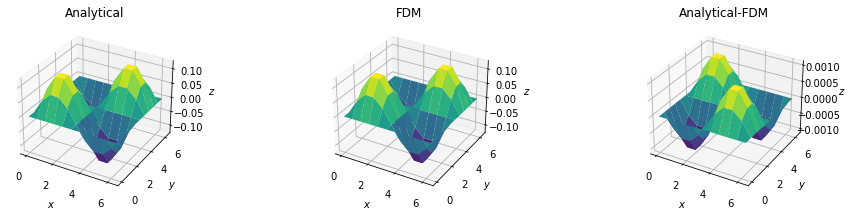

N = 20
Size of time step tau = 1.449275e-02
Number of time step M = 69


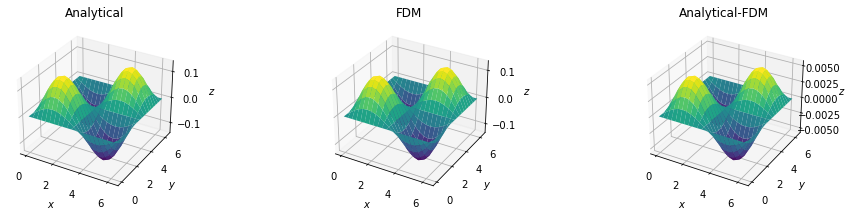

N = 40
Size of time step tau = 1.449275e-02
Number of time step M = 69


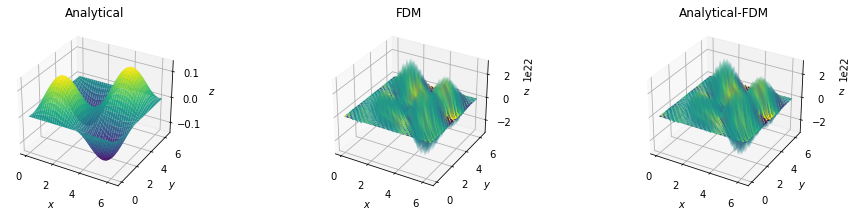

THETA = 1.0
N = 10
Size of time step tau = 1.449275e-02
Number of time step M = 69


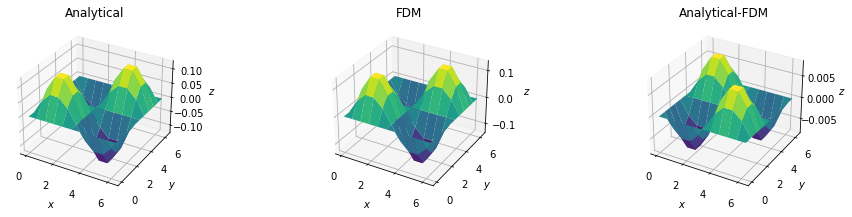

N = 20
Size of time step tau = 1.449275e-02
Number of time step M = 69


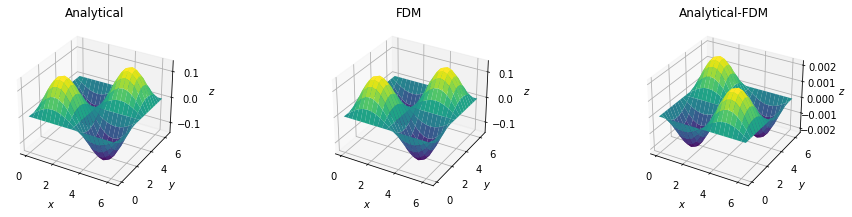

N = 40
Size of time step tau = 1.449275e-02
Number of time step M = 69


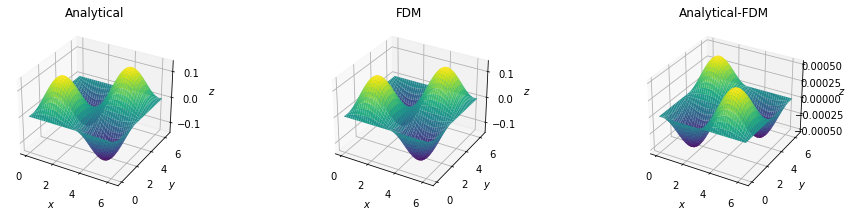

THETA = 0.5
N = 10
Size of time step tau = 1.449275e-02
Number of time step M = 69


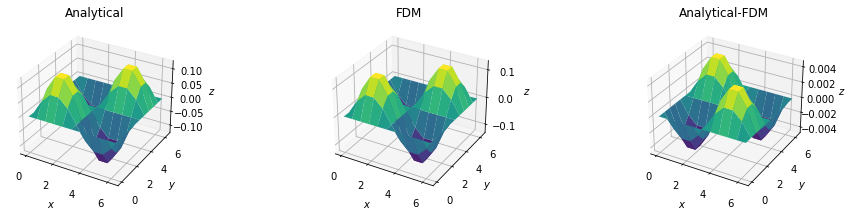

N = 20
Size of time step tau = 1.449275e-02
Number of time step M = 69


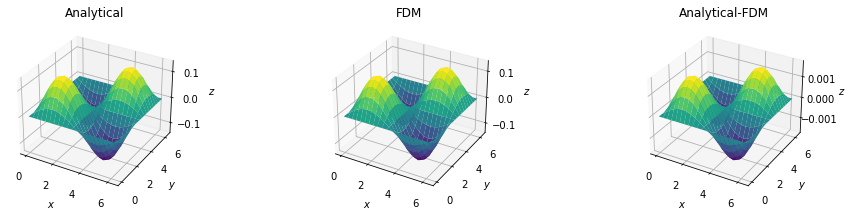

N = 40
Size of time step tau = 1.449275e-02
Number of time step M = 69


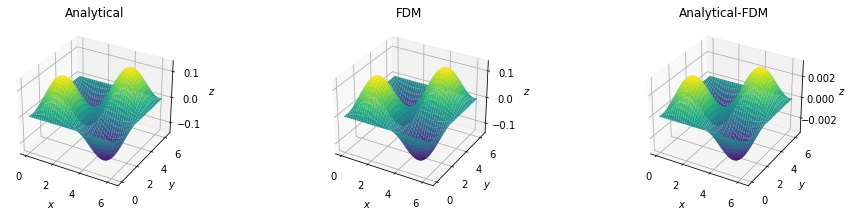

In [28]:
Ns = [10,20,40]
thetas = [0, 1.0, 0.5]
L = 2*np.pi
M = 69
t1 = 1
t0 = 0
T = np.linspace(t0, t1, M+1)
tau = (t1-t0)/M

for theta in thetas:
    print(f'THETA = {theta}')

    for N in Ns:
        X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]
        
        U_analytic = []
        for t in T:
            U_analytic.append(np.exp(-2 * t)*u_0(X,Y))

        print(f'N = {N}')
        U_h = fdm_solve(t0, t1, M, X, Y, theta, u_0, g_D, f,tau)
        
        pt.plot_comparison_2D(X,Y,U_analytic[-1], U_h[-1], title_f1='Analytical', title_f2='FDM', title_diff='Analytical-FDM')

**d**) Now we have a closer look at the CFL condition stating that in two space dimensions,
the explicit Euler scheme given by $\theta = 0$ needs to satisfy
$$
\tau \leqslant h^2/4
$$
to render the full discretization scheme stable in the discrete $l^2$ norm.
(Note that in the lecture, we derived the condition $\tau \leqslant h^2/2$ for *one* space dimension.)

Define $\tau$ as follows
$$
\tau = \alpha h^2/4
$$
with  a safety factor $\alpha$. Then do the following:

* Solve the heat equation using the explicit Euler for $N = 20$ and $\alpha = 0.1, 1, 10$. Do you see any large effects? 
**Hint/Remark:** "Suprisingly" enough this experiments does not reveal any kind
of instabilities. The reason is that the initial grid vector $(U^0)_{ij} = \sin(x_i)\sin(y_i)$ you computed
from $u_0(x,y)$ is an eigenvector to the FDM matrix associated with one of the *smallest*
eigenvalues (let's call it $\lambda_{\mathrm{low}}$ which do not grow with decreasing mesh size h. Thus $U^k$ computes to
$$
U^k = (Id - \tau A_h)^k U_0 = (1- \tau \lambda_{\mathrm{low}})^k U_0 
$$
leading us to the much less severe time step restriction 
$\tau \leqslant 2/\lambda_{\mathrm{low}}$ *indendent* of $h$.


* Next, add a tiny $\epsilon=0.001$-shift to the $x$ and $y$ argument of the initial data
(that is, $u_0(x, y)\ = \sin(x+\epsilon)\sin(y+\epsilon)$ and change the boundary condition accordingly. Redo the experiment for the same $N$ and $\alpha = 1.0, 1.5, 2.0$ and plot the resulting solution. What do you observe now?
**Remark:** now the discrete initial vector is *not* an eigenvector of the FDM matrix
anymore. Taking powers of $(Id - \tau A_h)$ does act on *all* frequencies/eigenvalues,
requiring to obey the CFL stability condition.

* Finally use as initial data the step function (code given below)
$$
u_0(x,y) = 
\begin{cases}
1 \quad \text{if } |x -  \pi| < \pi/3  \wedge |y -  \pi| < \pi/3
\\
0 \quad \text{else.}
\end{cases}
$$
Redo the experiment for $N=20$ and $\alpha = 0.8, 1.0, 1.2$.
and plot the resulting solution for $\alpha = 0.8, 1.0, 1.2$.
**Hint** This example is far worse than the $\epsilon$-"shifted" $\sin(x)\sin(y)$ which
produced an "almost" eigenvector as inital data.


THETA = 0
ALPHAS = 0.1
[0.31415927]
N = 20
Size of time step tau = 2.467401e-03
Number of time step M = 69


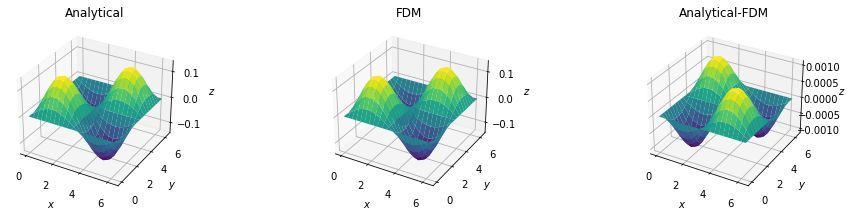

ALPHAS = 1.0
[0.31415927]
N = 20
Size of time step tau = 2.467401e-02
Number of time step M = 69


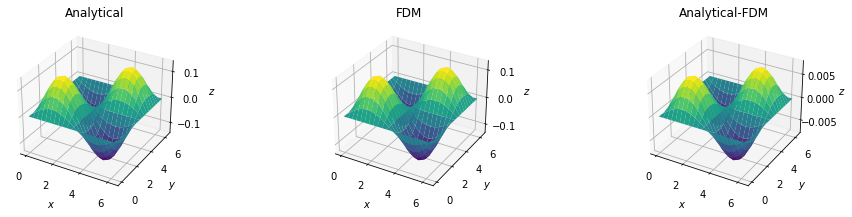

ALPHAS = 10
[0.31415927]
N = 20
Size of time step tau = 2.467401e-01
Number of time step M = 69


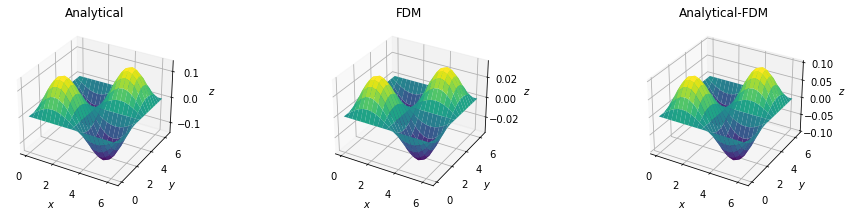

In [37]:
Ns = [20]
thetas = [0]
alphas = [0.1, 1.0, 10]
L = 2*np.pi
M = 69
t1 = 1
t0 = 0
T = np.linspace(t0, t1, M+1)


for theta in thetas:
    print(f'THETA = {theta}')

    for N in Ns:
        for alpha in alphas:
            print(f'ALPHAS = {alpha}')
            X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]
            h = X[1]-X[0]
            tau = alpha*h[0]*h[0]/4.0
            U_analytic = []
            for t in T:
                U_analytic.append(np.exp(-2 * t)*u_0(X,Y))

            print(f'N = {N}')
            U_h = fdm_solve(t0, t1, M, X, Y, theta, u_0, g_D, f,tau)
            
            pt.plot_comparison_2D(X,Y,U_analytic[-1], U_h[-1], title_f1='Analytical', title_f2='FDM', title_diff='Analytical-FDM')




In [26]:
def fdm_solve_2(t0, t1, M, X, Y, theta, u0, gD, f,tau,f_2,epsilon):
    # Step size
    L = X[len(X)-1]-X[0]
    h = X[1]-X[0]
    N = int(L/h)

    # Define gridmap assuming a row-wise numbering (Steal it from Lab 02) 
    def gm(i,j):
        return i + j * (N+1)

    #  Define (sparse) grid representation for evaluation of F
    #  and plotting

    # Choose first tau and then number of step size accordingly (or the other way around). 
    

    # This would be a safe choice of tau satisfying the CFL condition
    # alpha = 0.1
    #tau = alpha*h*h/4

    print("Size of time step tau = %e" % tau)
    print("Number of time step M = %d" %M)

    # Define your theta 
    bartheta = 1 - theta

    # Total number of unknowns is N_unk = (N+1)*(N+1)
    N_unk = (N+1)**2

    # Sparse identity matrix ajnd convert it immediately to csc format (not csr this time!)
    Id = sp.identity(N_unk).tocsc()

    # Compute A_h (only needed once!)
    # and convert it immediately to csc format for fast matrix*vector multiplication 
    # and fast matrix addition
    A_h = fdm_poisson2d_matrix(h, N, gm)

    # Compute total matrix B_h + tau*theta A_h
    A_tot = Id + tau*theta*A_h

    A_tot_LU = sp.linalg.factorized(A_tot)

    # Compute total matrix B_h - tau*bartheta A_h
    B_tot = Id - tau*bartheta*A_h

    # Current time and time step
    t, k = t0, 0

    # Initial condition 
    # Compute and plot it first
    U_grid = u0(X+epsilon, Y+epsilon)
    #pt.plot2D(X, Y, U_grid, title="Initial value $U^0$")

    # We have to flatten out the resulting (N+1)*(N+1) array using ravel()
    U = U_grid.ravel()
    U_list = [ U_grid ]
    
    # Start time stepping 
    while t < t1:
        # New time and time step
        t += tau
        k += 1
        #print("Solving for time step k=%d and time t=%e" %(k,t))

        # Compute right hand side by
        # 1) Apply matrix Id -  bartheta \tau A_h to U^{k-1} 
        rhs = B_tot@U # Matrix-vector multiplication

        # 2) Compute contributions from f at t^{k-1} and t^k
        rhs += tau*bartheta*f(X, Y, t-tau).ravel()
        rhs += tau*bartheta*f(X,Y,t).ravel()

        # Compute and apply bcs to rhs
        G_D = gD(X, Y, t,f_2).ravel()
        apply_bcs(rhs, G_D, N, gm)

        #Solve system (only necessary for theta > 0)
        if theta != 0:
            U = A_tot_LU(rhs)
        else:
            U = rhs

        U_list.append(U.copy().reshape((N+1, N+1)))
    return U_list

In [27]:
def g_D(x, y, t, f):
    a = 0*np.ones_like(x)*np.ones_like(y)
    a[0] = f(x,y[0][0],t).flatten()
    a[-1] = f(x,y[0][-1],t).flatten()
    a[:,0] = f(x[0][0],y,t).flatten()
    a[:,-1] = f(x[0][-1],y,t).flatten()
        
    return a

THETA = 0
ALPHAS = 1
N = 20
Size of time step tau = 2.467401e-02
Number of time step M = 69


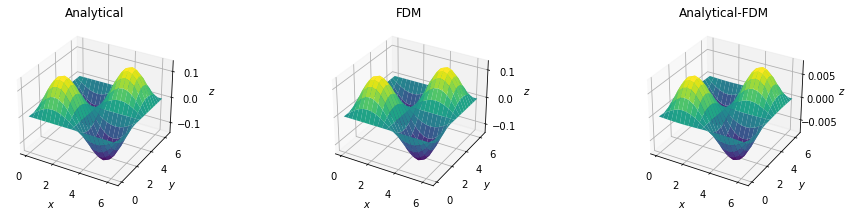

ALPHAS = 1.5
N = 20
Size of time step tau = 3.701102e-02
Number of time step M = 69


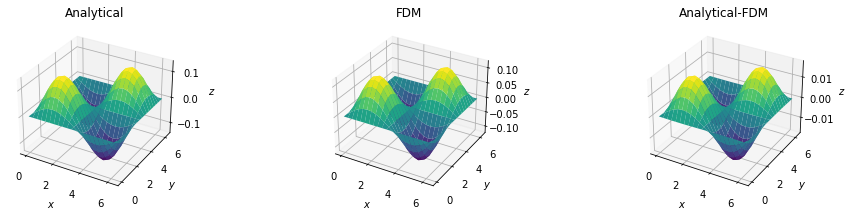

ALPHAS = 2
N = 20
Size of time step tau = 4.934802e-02
Number of time step M = 69


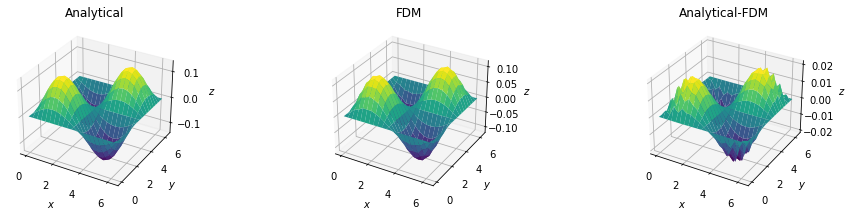

In [28]:
Ns = [20]
thetas = [0]
alphas = [1, 1.5, 2]
L = 2*np.pi
M = 69
t1 = 1
t0 = 0
T = np.linspace(t0, t1, M+1)
epsilon = 0.001
f_2 = lambda x,y,t: np.exp(-2 * t)*u_0(x+epsilon,y+epsilon)

for theta in thetas:
    print(f'THETA = {theta}')

    for N in Ns:
        for alpha in alphas:
            print(f'ALPHAS = {alpha}')
            X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]
            h = X[1]-X[0]
            tau = alpha*h[0]*h[0]/4.0
            U_analytic = []
            for t in T:
                U_analytic.append(np.exp(-2 * t)*u_0(X,Y))

            print(f'N = {N}')
            U_h = fdm_solve_2(t0, t1, M, X, Y, theta, u_0, g_D, f,tau,f_2,epsilon)
            
            pt.plot_comparison_2D(X,Y,U_analytic[-1], U_h[-1], title_f1='Analytical', title_f2='FDM', title_diff='Analytical-FDM')




In [121]:
def u_0_2(x,y):
    u = 0*np.ones_like(x)*np.ones_like(y)
    for i,a in zip(x.flatten(),range(0,x.shape[0]+1)):
        for j,b in zip(y.flatten(),range(0,y.shape[1]+1)):
            if ((np.abs(i-np.pi) < np.pi/3) and (np.abs(j-np.pi) < np.pi/3)):
                u[a,b] = 1
    return u




In [12]:
def u_0_step(x, y):
    step = 0*np.ones_like(x)*np.ones_like(y)

    # Not so elegant :)
    def is_inside(x, y):
        eps = 1e-10
        return  np.abs(x - np.pi) < np.pi/3  and np.abs(y - np.pi) < np.pi/3

    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            if is_inside(x[i,0], y[0,j]):
                step[i,j] = 1
    return step

THETA = 0
ALPHAS = 0.8
N = 20
Size of time step tau = 1.973921e-02
Number of time step M = 69


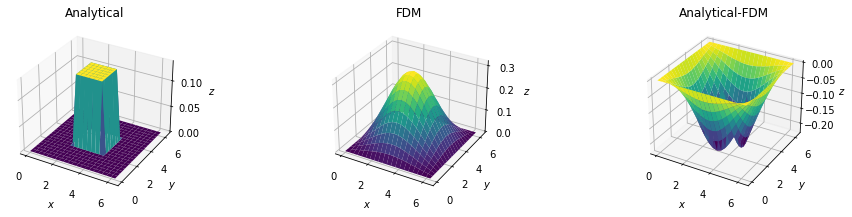

ALPHAS = 1.0
N = 20
Size of time step tau = 2.467401e-02
Number of time step M = 69


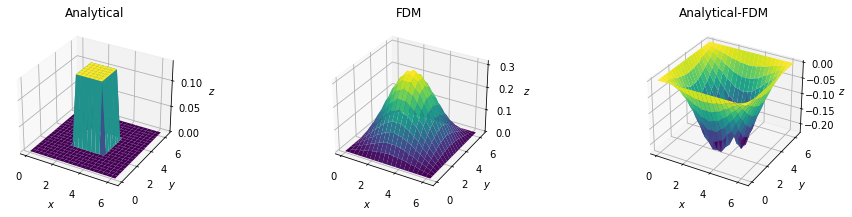

ALPHAS = 1.2
N = 20
Size of time step tau = 2.960881e-02
Number of time step M = 69


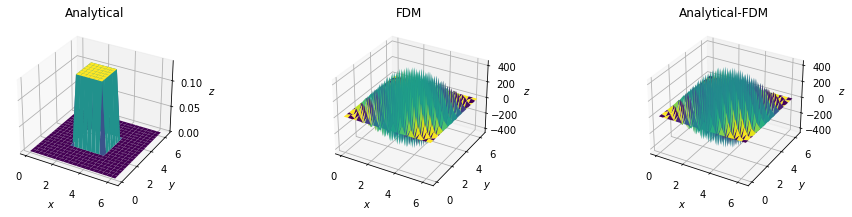

In [14]:
Ns = [20]
thetas = [0]
alphas = [0.8, 1.0, 1.2]
L = 2*np.pi
M = 69
t1 = 1
t0 = 0
T = np.linspace(t0, t1, M+1)
epsilon = 0.0
f_2 = lambda x,y,t: np.exp(-2 * t)*u_0(x+epsilon,y+epsilon)


for theta in thetas:
    print(f'THETA = {theta}')

    for N in Ns:
        for alpha in alphas:
            print(f'ALPHAS = {alpha}')
            X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]
            h = X[1]-X[0]
            tau = alpha*h[0]*h[0]/4.0
            U_analytic = []
            for t in T:
                U_analytic.append(np.exp(-2 * t)*u_0_step(X+epsilon,Y+epsilon))

            print(f'N = {N}')
            U_h = fdm_solve_2(t0, t1, M, X, Y, theta, u_0_step, g_D, f,tau,f_2)
            
            pt.plot_comparison_2D(X,Y,U_analytic[-1], U_h[-1], title_f1='Analytical', title_f2='FDM', title_diff='Analytical-FDM')




### Code Snippet

For the step function you can integrate the following code snippet.

## Problem 2 (Finite Element Method)

**a**) We repeat exercise 1a) but this time the spatial discretization will be based on a finite element method. Of course, we will make heavy use of the
code bits and pieces implemented previously in Lab 04.

To encourage code reuse, wrap your assembler functions from Lab 04
* assemble_mass_matrix
* assemble_stiffness_matrix
* assemble_load_vector 

into a separate assembler module named $\texttt{assemble.py}$ (Don't forget to include helper like $\texttt{compute\_hat\_grad}$). In principle, the module should like this:

In [ ]:
# assemble.py module
import numpy as np
import scipy.sparse as sp

def compute_hat_gradients(tri):
    # Compute area
    ....

    return ...

def assemble_stiffness_matrix(P, T):
    # Create matrix
    ...
    
    return A

def assemble_mass_matrix(P, T):
    ...

    return M

# And so one


Then you can simply use the functions from your new cool module by importing everything
into this notebook:

In [41]:
import assemble as ass

Next, we split our previous $\texttt{apply\_bcs}$ functions into two parts:
* one which manipulates the rows related to the Dirichlet nodes in a given matrix
(as described in Lab 04) and which will be needed only once.
* one which incorporates the Dirichlet data into given rhs vector b (needed in every time step)

Of course, it would be nice to encapsulate these functions into the $\text{assemble.py}$ module as well, so move them there and make sure that you rerun the cell with the 
```Python
from assemble import *
```
statement to reimport your new functions.

Finally, do the same with our 
```extract_nodes(P, inside_domain)``` from Lab 04.

Now you are well equipped to implement your own solver following closely the FDM based implementation. Start again by defining functions for the given data.

In [32]:
# Exact solution (to be used to testing purpose later)
def u_ex(x, y, t):
    return np.exp(-2*t)*np.sin(x)*np.sin(y)

# Right hand side
def f(x, y, t):
    return 0*np.ones_like(x)

# Initial condition
def u_0(x, y):
    return np.sin(x)*np.sin(y)

# Boundary condition
def g_D(x, y, t):
    return 0*np.ones_like(x)

# Start/end time
t0, T = 0, 1

Next, we define the dimensions of the domain and the Dirichlet boundary.

In [48]:
def on_dirichlet_boundary(x):
    eps = 1e-12
    L = 2*np.pi
    return  (x[0] < eps or x[0] > L - eps or
             x[1] < eps or x[1] > L - eps)

def extract_nodes(P, inside_domain):
    return [ i for i in range(P.shape[0]) if inside_domain(P[i]) ]

def apply_bcs_to_A(A, dirichlet_nodes):
    # Incorporate boundary conditions in matrix A
    # Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # Set diagonal to one
    A[dirichlet_nodes, dirichlet_nodes] = 1

def apply_bcs_to_b(b, g_D_values, dirichlet_nodes):
    # Incorporate boundary condition in vector b
    b[dirichlet_nodes] = g_D_values

As usual, you need a mesh. (Don't forget to import the meshtools and plottools module from Lab 04!)

In [34]:
import meshtools as mt
# Define number of subdivision in each spatial direction
N = 10

# Mesh size
h = 2*np.pi/N

# Mesh and coordinates
points, triangles = mt.rectangle_mesh((0,0), (L,L), N, N)
X = points[:, 0]
Y = points[:, 1]

In [36]:
# Define tau, number of time steps M_t , theta, thetabar next.
theta = 0
bartheta = 1-theta
M_t = 69
tau = (T-t0)/M_t



Now you can assemble the required mass and stiffness matrices and compute
the matrices which are involved in the left and right hand side of a time step computation.
As before,  Dirichlet conditions must be accounted for in the lhs matrix.

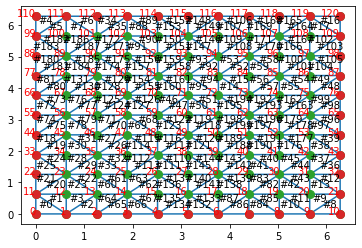

In [50]:
# Compute mass matrix
M = ass.assemble_mass_matrix(points, triangles)

# Compute A_h (only needed once!)
a = lambda x,y : 1
A_h = ass.assemble_stiffness_matrix(points,triangles,a)

# Compute total matrix for lhs (Change Id matrix to something else)
A_tot = M + tau*theta*A_h

# Compute total matrix for rhs
B_tot = M - bartheta*tau*A_h

# Extract Dirichlet nodes 
dirichlet_nodes  = extract_nodes(points, on_dirichlet_boundary)

# Plot them for visual check whether you extracted the right ones.
if N < 11:
    # Plot mesh including dirichlet nodes
    pt.plot_mesh_2d(points, triangles, dirichlet_nodes)

# Adjust rows associated with Dirchlet bc
apply_bcs_to_A(A_tot,dirichlet_nodes) 

# Convert final matrix to csc format and precompute LU composition
A_tot = A_tot.tocsc()

A_tot_LU = sp.linalg.factorized(A_tot)
#solve = A_tot_LU(B_tot)

Before you can start with the time step looping, an approximation of $u_0$ is needed.

/Users/joelnilsson/Documents/Dokument_Joels_MacPro/Universitet/numPDE/lab4/numpde-main-2/lab5/plottools.py:65: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


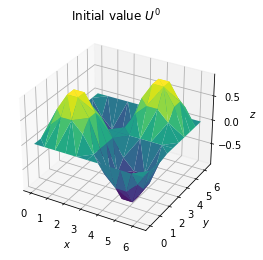

In [51]:
# Current time and time step
t, k = t0, 0

# (Indirect) interpolation (works only this way since a row wise
# numbering of the nodes is used when the mesh is created!
# Alternative would be to compute the L2 projection
U = u_0(X, Y)
pt.plot2D(X, Y, U, triangles=triangles, title="Initial value $U^0$")
U = U.ravel()

Finally, into the time step looping!

In [ ]:
# Start time stepping 
while t < T:

    # New time and time step
    t += tau
    k += 1

    # Compute right hand side action on U
    rhs = B_tot.dot(U)

    # Define f at theta midpoint using an anonymous lambda function 
    f_theta = lambda x,y : f(x,y, t-bartheta*tau)
    # and assemble the load vector using f_theta and add it to the rhs
    rhs += ...

    # Extract coordinates associated with Dirichlet nodes as before in Lab 04
    X_dc = ...
    Y_dc = ...

    # Evaluate g at boundary nodes and time t
    g_D_values = g_D(X_dc, Y_dc, t)

    # Apply Dirichlet boundary condition to rhs
    apply_bcs_to_b( ... )

    #Solve system
    U = solve( rhs )

Great, your are done! Time to plot things:

In [ ]:
pt.plot2D(X, Y, U, triangles=triangles, title="Final solution $U$ at t=%f" %t)

U_ex = u_ex(X, Y, t)
pt.plot_comparison_2D(X, Y, U_ex, U, "$U_{ex}$", "$U_h$", "$U_{ex}-U_h$", triangles=triangles)

To generate some animated plots for FEM solution adapt your code as folllows:

1) Add the code line

    U_list = [ U ]

just before you start the time-stepping.

2) Add the code line

    U_list.append(U.copy())

right after to solved for the new U in your current time step.

3) Add the line 

    pt.plot_2D_animation(X, Y, U_list, triangles=triangles)

**c**) Finally, repeat the numerical experiment from 1 c) with your FEM based solver.